IMPORT


In [0]:
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import logging

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, DataLoader
from torch.backends import cudnn

import torchvision
from torchvision import transforms
from torchvision.models import alexnet
from torchvision.models import resnet18

from PIL import Image
from tqdm import tqdm
import torch
import torch.nn as nn
from torchvision.models.utils import load_state_dict_from_url

SET ARGUMENTS


In [0]:

DEVICE = 'cuda' # 'cuda' or 'cpu'

NUM_CLASSES = 1000

BATCH_SIZE = 512    # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results

LR = 1e-3           # The initial Learning Rate
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-5  # Regularization, you can keep this at the default

NUM_EPOCHS = 10     # Total number of training epochs (iterations over dataset)
STEP_SIZE = 5      # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.1         # Multiplicative factor for learning rate step-down

ALPHA = 0.001


LOG_FREQUENCY = 10

DEFINE DATA PREPROCESSING


In [0]:
# Define transforms for training phase
train_transform = transforms.Compose([transforms.Resize(256),      # Resizes short size of the PIL image to 256
                                      transforms.CenterCrop(224),  # Crops a central square patch of the image
                                                                   # 224 because torchvision's AlexNet needs a 224x224 input!
                                                                   # Remember this when applying different transformations, otherwise you get an error
                                      transforms.ToTensor(), # Turn PIL Image to torch.Tensor
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) # Normalizes tensor with mean and standard deviation
])
# Define transforms for the evaluation phase
eval_transform = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))                                    
])

DATASETS


In [4]:
# Clone github repository with data
if not os.path.isdir('./Homework3-PACS'):
  !git clone https://github.com/sofiaborgato/Homework3-PACS.git
  


PHOTO_DIR = 'Homework3-PACS/PACS/photo'
CARTOON_DIR = 'Homework3-PACS/PACS/cartoon'
SKETCH_DIR = 'Homework3-PACS/PACS/sketch'
ART_DIR = 'Homework3-PACS/PACS/art_painting'
from torchvision.datasets import VisionDataset

# Prepare Pytorch train/test Datasets
photo = torchvision.datasets.ImageFolder(PHOTO_DIR, transform=train_transform)
cartoon = torchvision.datasets.ImageFolder(CARTOON_DIR, transform=eval_transform)
sketch =torchvision.datasets.ImageFolder(SKETCH_DIR, transform=eval_transform)
art =torchvision.datasets.ImageFolder(ART_DIR, transform=eval_transform)


# Check dataset sizes
print('Photo Dataset: {}'.format(len(photo)))
print('Art Painting Dataset: {}'.format(len(art)))
print('Cartoon Dataset: {}'.format(len(cartoon)))
print('Sketch Dataset: {}'.format(len(sketch)))

Photo Dataset: 1670
Art Painting Dataset: 2048
Cartoon Dataset: 2344
Sketch Dataset: 3929


DEFINE DATA LOADERS


In [0]:
# Dataloaders iterate over pytorch datasets and transparently provide useful functions (e.g. parallelization and shuffling)
photo_dataloader = DataLoader(photo, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
cartoon_dataloader = DataLoader(cartoon, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
art_dataloader = DataLoader(art, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
sketch_dataloader = DataLoader(sketch, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

REVERS LAYER


In [0]:
import torch.nn as nn
from torch.autograd import Function

''' 
Very easy template to start for developing your AlexNet with DANN 
Has not been tested, might contain incompatibilities with most recent versions of PyTorch (you should address this)
However, the logic is consistent
'''
class ReverseLayerF(Function):
    # Forwards identity
    # Sends backward reversed gradients
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        output = grad_output.neg() * ctx.alpha

        return output, None

ALEX_NET


In [0]:
#from functions import ReverseLayerF
__all__ = ['AlexNet', 'alexnet']


model_urls = {
    'alexnet': 'https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth',
}


class AlexNet(nn.Module):

    def __init__(self, num_classes=1000):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
            
        )
        self.GDclassifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
            
        )

    

    def forward(self, x, ALPHA=None):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0),-1)
        if ALPHA is not None:
            reverse_feature = ReverseLayerF.apply(x, ALPHA)
            discriminator_output = self.GDclassifier(reverse_feature)
            return discriminator_output
        else:
            class_outputs = self.classifier(x)
            return class_outputs


def alexnet(pretrained=False, progress=True, **kwargs):
    r"""AlexNet model architecture from the
    `"One weird trick..." <https://arxiv.org/abs/1404.5997>`_ paper.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    model = AlexNet(**kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls['alexnet'],
                                              progress=progress)
        model.load_state_dict(state_dict, strict=False)

    return model

LOADING ALEXNET MODEL


In [0]:
net = alexnet(pretrained = True) # Loading AlexNet model

net.classifier[6] = nn.Linear(4096, 7)
net.GDclassifier[6]= nn.Linear(4096,2)

net.GDclassifier[1].weight.data = net.classifier[1].weight.data
net.GDclassifier[1].bias.data = net.classifier[1].bias.data

net.GDclassifier[4].weight.data = net.classifier[4].weight.data
net.GDclassifier[4].bias.data = net.classifier[4].bias.data

net.GDclassifier[6].weight.data = net.classifier[6].weight.data
net.GDclassifier[6].bias.data = net.classifier[6].bias.data

DEFINE LOSS FUNCTIONS


In [0]:
# Define loss function
criterion = nn.CrossEntropyLoss() # for classification, we use Cross Entropy

# Choose parameters to optimize
# To access a different set of parameters, you have to access submodules of AlexNet
# (nn.Module objects, like AlexNet, implement the Composite Pattern)
# e.g.: parameters of the fully connected layers: net.classifier.parameters()
# e.g.: parameters of the convolutional layers: look at alexnet's source code ;) 
parameters_to_optimize = net.parameters() # In this case we optimize over all the parameters of AlexNet

# Define optimizer
# An optimizer updates the weights based on loss
# We use SGD with momentum
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

# Define scheduler
# A scheduler dynamically changes learning rate
# The most common schedule is the step(-down), which multiplies learning rate by gamma every STEP_SIZE epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

TRAIN NO DANN

In [10]:
#TRAIN


net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
cudnn.benchmark = True # Calling this optimizes runtime
#Hyper-parameter to optimize
learning_rate_vector=[1e-2,1e-3]
epoch_vector=[50,30]
loss_val=[]

acc_train=[]
current_step = 0
best_accuracy = 0
loss_vector = []
tot_accuracy = []


for epoch in range(NUM_EPOCHS):
  print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, scheduler.get_lr()))

  # Iterate over the dataset
  running_correct_train=0
  for images, labels in photo_dataloader:
    # Bring data over the device of choice
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    net.train() # Sets module in training mode

    # PyTorch, by default, accumulates gradients after each backward pass
    # We need to manually set the gradients to zero before starting a new iteration
    optimizer.zero_grad() # Zero-ing the gradients

    # Forward pass to the network and computes gradient
    outputs = net(images)
    #calculte accuracy also on train set
    _, preds = torch.max(outputs.data, 1)
    running_correct_train += torch.sum(preds == labels.data).data.item()
    # Compute loss based on output and ground truth
    loss = criterion(outputs, labels)

    
    # Log loss
    if current_step % LOG_FREQUENCY == 0:
      print('Step {}, Loss {}'.format(current_step, loss.item()))

    # Compute gradients for each layer and update weights
    loss.backward()  # backward pass: computes gradients
    optimizer.step() # update weights based on accumulated gradients

    current_step += 1
  
  loss_vector.append(loss.item())
  acc_t=running_correct_train / float(len(photo))
  acc_train.append(acc_t)
  # Step the scheduler
  scheduler.step()

  #VALIDATION
  net.train(False) # Set Network to evaluation mode
  

  running_corrects = 0
  with torch.no_grad():
      for images, labels in tqdm(art_dataloader):
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        # Forward Pass
        outputs = net(images)
        # Get predictions
        _, preds = torch.max(outputs.data, 1)
        
        # Update Corrects
        running_corrects += torch.sum(preds == labels.data).data.item()
  # Calculate Accuracy
  accuracy = running_corrects / float(len(art))
  #loss on validation
  loss_val.append(criterion(outputs,labels))
  tot_accuracy.append(accuracy)
  print('Validation Accuracy: {}'.format(accuracy))

  if accuracy>best_accuracy:
    best_net = copy.deepcopy(net)
    best_accuracy=accuracy





Starting epoch 1/10, LR = [0.001]


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Step 0, Loss 2.049705982208252


100%|██████████| 4/4 [00:09<00:00,  2.31s/it]

Validation Accuracy: 0.2734375
Starting epoch 2/10, LR = [0.001]



100%|██████████| 4/4 [00:09<00:00,  2.27s/it]

Validation Accuracy: 0.388671875
Starting epoch 3/10, LR = [0.001]



100%|██████████| 4/4 [00:09<00:00,  2.34s/it]

Validation Accuracy: 0.46533203125
Starting epoch 4/10, LR = [0.001]


Step 10, Loss 0.30949071049690247


100%|██████████| 4/4 [00:08<00:00,  2.24s/it]

Validation Accuracy: 0.48974609375
Starting epoch 5/10, LR = [0.001]



100%|██████████| 4/4 [00:09<00:00,  2.27s/it]

Validation Accuracy: 0.48583984375
Starting epoch 6/10, LR = [1e-05]



100%|██████████| 4/4 [00:09<00:00,  2.27s/it]

Validation Accuracy: 0.4853515625
Starting epoch 7/10, LR = [0.0001]


Step 20, Loss 0.17052143812179565


100%|██████████| 4/4 [00:09<00:00,  2.28s/it]

Validation Accuracy: 0.48291015625
Starting epoch 8/10, LR = [0.0001]



100%|██████████| 4/4 [00:09<00:00,  2.29s/it]

Validation Accuracy: 0.48046875
Starting epoch 9/10, LR = [0.0001]



100%|██████████| 4/4 [00:09<00:00,  2.32s/it]

Validation Accuracy: 0.47802734375
Starting epoch 10/10, LR = [0.0001]



100%|██████████| 4/4 [00:09<00:00,  2.29s/it]

Validation Accuracy: 0.47802734375


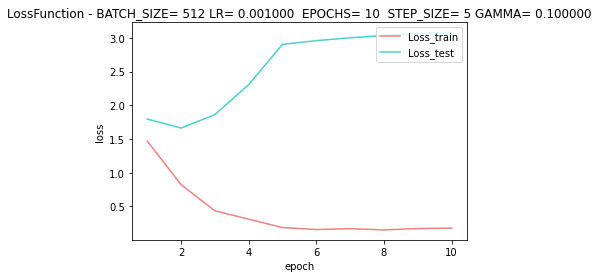

0.48974609375


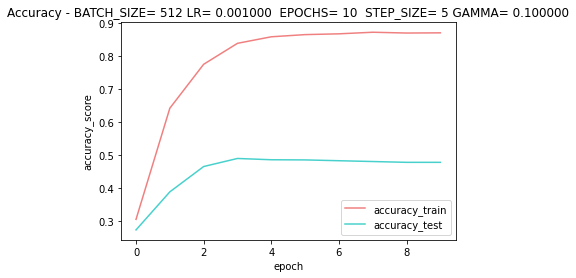

In [11]:
#PLOT_TRAIN_STATUS
tit = 'LossFunction - BATCH_SIZE= %d LR= %f  EPOCHS= %d  STEP_SIZE= %d GAMMA= %f' % (BATCH_SIZE, LR, NUM_EPOCHS, STEP_SIZE,GAMMA)
x=np.linspace(1,NUM_EPOCHS,NUM_EPOCHS)
#punti=[1,4,8,12,16,20,24]
plt.plot(x,loss_vector,color='lightcoral')
plt.plot(x,loss_val,color='mediumturquoise')
#plt.xticks(punti)
plt.title(tit)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Loss_train','Loss_test'],loc='upper right')
plt.show()
tit_2='Accuracy - BATCH_SIZE= %d LR= %f  EPOCHS= %d  STEP_SIZE= %d GAMMA= %f' %(BATCH_SIZE, LR, NUM_EPOCHS, STEP_SIZE,GAMMA)
plt.plot(acc_train,color='lightcoral')
plt.plot(tot_accuracy,color='mediumturquoise')
plt.legend(['accuracy_train','accuracy_test'],loc='best')
plt.title(tit_2)
plt.xlabel('epoch')
plt.ylabel('accuracy_score')
#plt.xticks(punti)
#print(acc_train)
print(best_accuracy)


In [12]:
#TEST

net = best_net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
net.train(False)

running_corrects = 0
for images, labels in tqdm(art_dataloader):
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    # Forward Pass
    outputs = net(images)

    # Get predictions
    _, preds = torch.max(outputs.data, 1)

    # Update Corrects
    running_corrects += torch.sum(preds == labels.data).data.item()

# Calculate Accuracy
accuracy = running_corrects / float(len(art))

print('Test Accuracy: {}'.format(accuracy))

100%|██████████| 4/4 [00:09<00:00,  2.30s/it]

Test Accuracy: 0.48974609375


TRAIN WITH DANN

In [0]:
#CREATE DATSET FOR TRAIN ON DANN 


In [14]:



#TRAIN with DANN
net = alexnet(pretrained = True) # Loading AlexNet modelnvolutional layer is nn.Conv2d
net.classifier[6] = nn.Linear(4096, 7)
net.GDclassifier[6]= nn.Linear(4096,2)

net.GDclassifier[1].weight.data = net.classifier[1].weight.data
net.GDclassifier[1].bias.data = net.classifier[1].bias.data

net.GDclassifier[4].weight.data = net.classifier[4].weight.data
net.GDclassifier[4].bias.data = net.classifier[4].bias.data

net.GDclassifier[6].weight.data = net.classifier[6].weight.data
net.GDclassifier[6].bias.data = net.classifier[6].bias.data

criterion = nn.CrossEntropyLoss()
parameters_to_optimize = net.parameters()
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)
net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
cudnn.benchmark = True # Calling this optimizes runtime
#Hyper-parameter to optimize
learning_rate_vector=[1e-2,1e-3]
epoch_vector=[50,30]
loss_val_dann=[]

acc_train_dann=[]
current_step = 0
best_accuracy_dann = 0
loss_vector_dann = []
tot_accuracy_dann = []
domain_loss_vect=[]


for epoch in range(NUM_EPOCHS):
  print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, scheduler.get_lr()))

  # Iterate over the dataset
  running_correct_train=0
  rc_domain=0
  for images, labels in photo_dataloader:
    # Bring data over the device of choice
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    net.train() # Sets module in training mode

    # PyTorch, by default, accumulates gradients after each backward pass
    # We need to manually set the gradients to zero before starting a new iteration
    optimizer.zero_grad() # Zero-ing the gradients

    # Forward pass to the network
    outputs = net(images)
    #calculte accuracy also on train set
    _, preds = torch.max(outputs.data, 1)
    running_correct_train += torch.sum(preds == labels.data).data.item()
    # Compute loss based on output and ground truth
    loss = criterion(outputs, labels)
    #Forward pass to domain classifier
    domain_output=net.forward(images,ALPHA)
    targets=torch.zeros(labels.size(0),dtype=torch.int64).to(DEVICE)
    domain_loss=criterion(domain_output,targets)
    domain_loss.backward()
    #forward pass to the discriminator  test dataset
    test_images,test_label=next(iter(art_dataloader))
    test_images=test_images.to(DEVICE)
    test_label=test_label.to(DEVICE)
    
    domain_output_test=net(test_images,ALPHA)
    targets=torch.ones(labels.size(0),dtype=torch.int64).to(DEVICE)
    domain_loss_test=criterion(domain_output_test,targets)
    
    
    domain_loss_test.backward()

    # Log loss
    if current_step % LOG_FREQUENCY == 0:
      print('Step {}, Loss {}'.format(current_step, loss.item()))

    # Compute gradients for each layer and update weights
    loss.backward()  # backward pass: computes gradients
    optimizer.step() # update weights based on accumulated gradients

    current_step += 1
  
  loss_vector_dann.append(domain_loss_test.item())
  acc_t=running_correct_train / float(len(photo))
  acc_train_dann.append(acc_t)
  domain_loss_vect.append(domain_loss_test.item())
  

  # Step the scheduler
  scheduler.step()

  #TEST
  net.train(False) # Set Network to evaluation mode
  

  running_corrects = 0
  with torch.no_grad():
      for images, labels in tqdm(art_dataloader):
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        # Forward Pass
        outputs = net(images)
        # Get predictions
        _, preds = torch.max(outputs.data, 1)
        
        # Update Corrects
        running_corrects += torch.sum(preds == labels.data).data.item()
  # Calculate Accuracy
  accuracy = running_corrects / float(len(art))
  #loss on validation
  loss_val_dann.append(criterion(outputs,labels))
  tot_accuracy_dann.append(accuracy)
  print('Validation Accuracy: {}'.format(accuracy))

  if accuracy>best_accuracy_dann:
    best_net_dann = copy.deepcopy(net)
    best_accuracy_dann=accuracy

Starting epoch 1/10, LR = [0.001]


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Step 0, Loss 2.3266382217407227


100%|██████████| 4/4 [00:10<00:00,  2.65s/it]

Validation Accuracy: 0.2685546875
Starting epoch 2/10, LR = [0.001]



100%|██████████| 4/4 [00:10<00:00,  2.68s/it]

Validation Accuracy: 0.373046875
Starting epoch 3/10, LR = [0.001]



100%|██████████| 4/4 [00:10<00:00,  2.62s/it]

Validation Accuracy: 0.4228515625
Starting epoch 4/10, LR = [0.001]


Step 10, Loss 0.3266502916812897


100%|██████████| 4/4 [00:10<00:00,  2.50s/it]

Validation Accuracy: 0.435546875
Starting epoch 5/10, LR = [0.001]



100%|██████████| 4/4 [00:09<00:00,  2.50s/it]

Validation Accuracy: 0.43212890625
Starting epoch 6/10, LR = [1e-05]



100%|██████████| 4/4 [00:10<00:00,  2.68s/it]

Validation Accuracy: 0.43310546875
Starting epoch 7/10, LR = [0.0001]


Step 20, Loss 0.1816827654838562


100%|██████████| 4/4 [00:10<00:00,  2.62s/it]

Validation Accuracy: 0.4345703125
Starting epoch 8/10, LR = [0.0001]



100%|██████████| 4/4 [00:09<00:00,  2.47s/it]

Validation Accuracy: 0.43701171875
Starting epoch 9/10, LR = [0.0001]



100%|██████████| 4/4 [00:09<00:00,  2.44s/it]

Validation Accuracy: 0.43994140625
Starting epoch 10/10, LR = [0.0001]



100%|██████████| 4/4 [00:10<00:00,  2.63s/it]

Validation Accuracy: 0.44140625


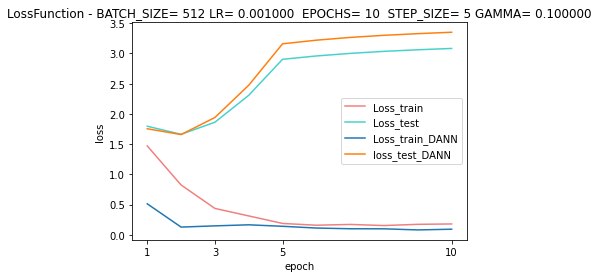

0.44140625


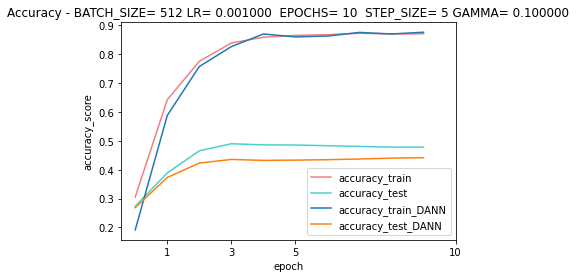

In [15]:
#PLOT_DANN_NO_DANN
tit = 'LossFunction - BATCH_SIZE= %d LR= %f  EPOCHS= %d  STEP_SIZE= %d GAMMA= %f' % (BATCH_SIZE, LR, NUM_EPOCHS, STEP_SIZE,GAMMA)
x=np.linspace(1,NUM_EPOCHS,NUM_EPOCHS)
punti=[1,3,5,10]
plt.plot(x,loss_vector,color='lightcoral')
plt.plot(x,loss_val,color='mediumturquoise')#
plt.plot(x,loss_vector_dann)
plt.plot(x,loss_val_dann)
#plt.plot(x,loss_vector_dann)
plt.xticks(punti)
plt.title(tit)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Loss_train','Loss_test','Loss_train_DANN','loss_test_DANN','loss_domain'],loc='best')
plt.show()
tit_2='Accuracy - BATCH_SIZE= %d LR= %f  EPOCHS= %d  STEP_SIZE= %d GAMMA= %f' %(BATCH_SIZE, LR, NUM_EPOCHS, STEP_SIZE,GAMMA)
plt.plot(acc_train,color='lightcoral')
plt.plot(tot_accuracy,color='mediumturquoise')
plt.plot(acc_train_dann)
plt.plot(tot_accuracy_dann)
#plt.plot(domain_acc)
plt.legend(['accuracy_train','accuracy_test','accuracy_train_DANN','accuracy_test_DANN'],loc='best')
plt.title(tit_2)
plt.xlabel('epoch')
plt.ylabel('accuracy_score')
plt.xticks(punti)
#print(acc_train)
print(best_accuracy_dann)

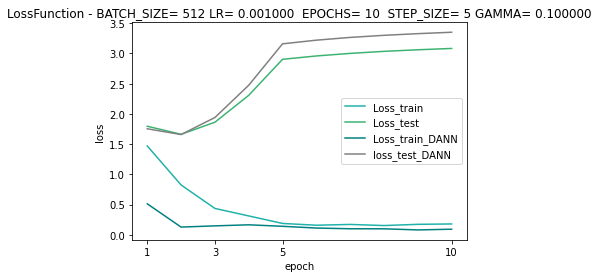

0.44140625


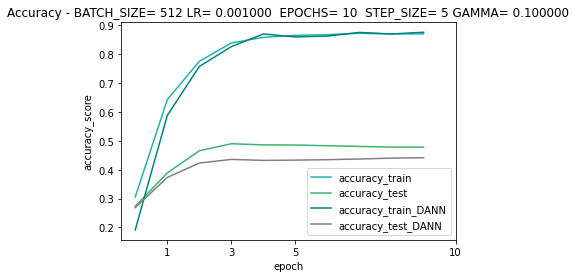

In [16]:
#PLOT_DANN_NO_DANN
tit = 'LossFunction - BATCH_SIZE= %d LR= %f  EPOCHS= %d  STEP_SIZE= %d GAMMA= %f' % (BATCH_SIZE, LR, NUM_EPOCHS, STEP_SIZE,GAMMA)
x=np.linspace(1,NUM_EPOCHS,NUM_EPOCHS)
punti=[1,3,5,10]
plt.plot(x,loss_vector,color='lightseagreen')
plt.plot(x,loss_val,color='mediumseagreen')
plt.plot(x,loss_vector_dann, color='teal')
plt.plot(x,loss_val_dann,color='gray')
plt.xticks(punti)
plt.title(tit)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Loss_train','Loss_test','Loss_train_DANN','loss_test_DANN'],loc='best')
plt.show()
tit_2='Accuracy - BATCH_SIZE= %d LR= %f  EPOCHS= %d  STEP_SIZE= %d GAMMA= %f' %(BATCH_SIZE, LR, NUM_EPOCHS, STEP_SIZE,GAMMA)
plt.plot(acc_train,color='lightseagreen')
plt.plot(tot_accuracy,color='mediumseagreen')
plt.plot(acc_train_dann,color='teal')
plt.plot(tot_accuracy_dann,color='gray')
plt.legend(['accuracy_train','accuracy_test','accuracy_train_DANN','accuracy_test_DANN'],loc='best')
plt.title(tit_2)
plt.xlabel('epoch')
plt.ylabel('accuracy_score')
plt.xticks(punti)
#print(acc_train)
print(best_accuracy_dann)

In [17]:
#TEST

net = best_net_dann.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
net.train(False)

running_corrects = 0
for images, labels in tqdm(art_dataloader):
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    # Forward Pass
    outputs = net(images)

    # Get predictions
    _, preds = torch.max(outputs.data, 1)

    # Update Corrects
    running_corrects += torch.sum(preds == labels.data).data.item()

# Calculate Accuracy
accuracy = running_corrects / float(len(art))

print('Test Accuracy: {}'.format(accuracy))

100%|██████████| 4/4 [00:10<00:00,  2.60s/it]

Test Accuracy: 0.44140625


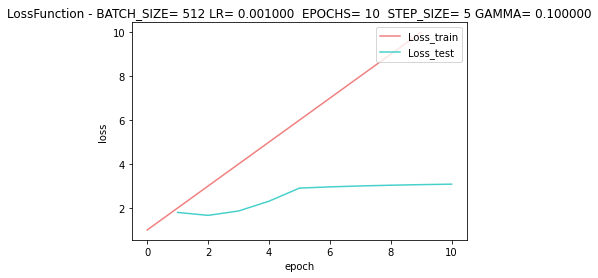

0.48974609375


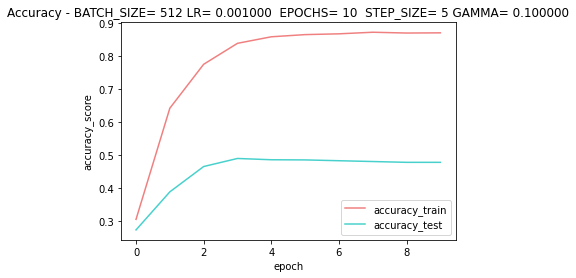

In [18]:
#PLOT DOMAIN STATUS
tit = 'LossFunction - BATCH_SIZE= %d LR= %f  EPOCHS= %d  STEP_SIZE= %d GAMMA= %f' % (BATCH_SIZE, LR, NUM_EPOCHS, STEP_SIZE,GAMMA)
x=np.linspace(1,NUM_EPOCHS,NUM_EPOCHS)
#punti=[1,4,8,12,16,20,24]
plt.plot(x,color='lightcoral')
plt.plot(x,loss_val,color='mediumturquoise')
#plt.xticks(punti)
plt.title(tit)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Loss_train','Loss_test'],loc='upper right')
plt.show()
tit_2='Accuracy - BATCH_SIZE= %d LR= %f  EPOCHS= %d  STEP_SIZE= %d GAMMA= %f' %(BATCH_SIZE, LR, NUM_EPOCHS, STEP_SIZE,GAMMA)
plt.plot(acc_train,color='lightcoral')
plt.plot(tot_accuracy,color='mediumturquoise')
plt.legend(['accuracy_train','accuracy_test'],loc='best')
plt.title(tit_2)
plt.xlabel('epoch')
plt.ylabel('accuracy_score')
#plt.xticks(punti)
#print(acc_train)
print(best_accuracy)


In [19]:
print(rc_domain)

0
